In [2]:
import tensorflow as tf
import numpy as np
import re
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2 as cv
import time
import random
import matplotlib.pyplot as plt
# from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU, Multiply, Concatenate)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import keras_cv


In [3]:
pip install pycocotools

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Dataset Download

In [4]:
train_images = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/train1/real/image/'
train_maps  = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/train1/real/label/'

test_images = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/test/image/'
test_maps = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/test/label/'

classes =['NO_DIE','DIE_BROKEN','DIE_INK','DIE_CRACK']
B = 3
N_CLASSES = len(classes)
OUTPUT_DIM = B*(5 + 4)
H,W = 416, 416

In [5]:
train_images1 = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/train2/synthetic/DIE_BROKEN/'
train_images2 = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/train2/synthetic/DIE_CRACK/'
train_images3 = '/kaggle/input/new1-dataset/dataset/defect_images/dataset1/train2/synthetic/DIE_INK/'
syn_im_paths = []

for i in os.listdir(train_images1):
    syn_im_paths.append(train_images1+i[:-3]+'bmp')

for i in os.listdir(train_images2):
    syn_im_paths.append(train_images2+i[:-3]+'bmp')

for i in os.listdir(train_images3):
    syn_im_paths.append(train_images3+i[:-3]+'bmp')

print(len(syn_im_paths))

600


In [6]:
def preprocess_xml(filename):
    filename = filename.decode('utf-8') if isinstance(filename, bytes) else filename
  
    if filename.find('synthetic')==-1:
      tree = ET.parse(filename)
      root = tree.getroot()
      size_tree = root.find('size')
      height = float(size_tree.find('height').text)
      width = float(size_tree.find('width').text)
      bounding_boxes=[]
      for object_tree in root.findall('object'):
        for bounding_box in object_tree.iter('bndbox'):
          xmin = (float(bounding_box.find('xmin').text))
          ymin = (float(bounding_box.find('ymin').text))
          xmax = (float(bounding_box.find('xmax').text))
          ymax = (float(bounding_box.find('ymax').text))
          break
        class_name = object_tree.find('name').text
        class_dict={classes[i]:i for i in range(len(classes))}
        bounding_box = [
            (xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
            (ymax-ymin)/height,class_dict[class_name]]
        bounding_boxes.append(bounding_box)
      return tf.convert_to_tensor(bounding_boxes)
        
    if filename.find('synthetic')!=-1:
        filename = filename.decode('utf-8') if isinstance(filename, bytes) else filename
        x_numbers = re.findall(r'X(\d+)', filename)
        y_numbers = re.findall(r'Y(\d+)', filename)
        img = tf.io.decode_bmp(tf.io.read_file(filename),3)
        width = img.shape[1]
        height = img.shape[0]
        class_name = ' '
        for i in classes:
            if filename.find(i) !=-1:
              class_name = i
        
        xmin = float(x_numbers[0])
        ymin = float(y_numbers[0])
        xmax = float(x_numbers[1])
        ymax = float(y_numbers[1])
        
        class_dict={classes[i]:i for i in range(len(classes))}
        bounding_box = [
          (xmin+xmax)/(2*width)+1e-7,(ymin+ymax)/(2*height)+1e-7,(xmax-xmin)/width+1e-7,
          (ymax-ymin)/height+1e-7,class_dict[class_name]]
        if 0. in bounding_box:
            tf.print(filename)
        return tf.convert_to_tensor([bounding_box],dtype=tf.float32)


In [7]:
def generate_output(bounding_boxes):
    out_b=[]
    for SPLIT_SIZE in [52,26,13]:
        output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))
        for b in range(len(bounding_boxes)):
            grid_x = bounding_boxes[b, 0] * SPLIT_SIZE
            grid_y = bounding_boxes[b, 1] * SPLIT_SIZE
            i = int(grid_x)
            j = int(grid_y)
            # if (output_label[i,j,0]==0) :
            output_label[i, j, 0:5]=([1., grid_x % 1, grid_y % 1, bounding_boxes[b, 2], bounding_boxes[b, 3]])
            output_label[i, j, 5 + int(bounding_boxes[b, 4])]=1.
        out_b.append(tf.convert_to_tensor(output_label,tf.float32))
    return out_b[0],out_b[1],out_b[2]

In [8]:
im_paths = []
xml_paths = []

test_im_paths = []
test_xml_paths= []
error_lists = ['R7C139X0Y0L0W0.xml','R2C143X0Y0L0W0.xml','R8C127X0Y0L0W0.xml','R6C104X0Y0L0W0.xml']
for i in os.listdir(train_maps):
    if i in error_lists:
        continue
    im_paths.append(train_images+i[:-3]+'bmp')
    xml_paths.append(train_maps+i)

for i in os.listdir(test_maps):
    if i in ['R26C38X184Y202L265W277.xml','R9C142X0Y0L0W0.xml']:
        continue
    test_im_paths.append(test_images+i[:-3]+'bmp')
    test_xml_paths.append(test_maps+i)

print(len(im_paths), len(xml_paths))
print(len(test_im_paths), len(test_xml_paths))


543 543
271 271


In [9]:
val_im_paths = im_paths[int(0.9*len(im_paths)):]
val_xml_paths = xml_paths[int(0.9*len(xml_paths)):]

im_paths = im_paths[:int(0.9*len(im_paths))]
xml_paths = xml_paths[:int(0.9*len(xml_paths))]

print(len(im_paths), len(xml_paths))
print(len(val_im_paths), len(val_xml_paths))

488 488
55 55


In [10]:
im_paths += syn_im_paths
xml_paths += syn_im_paths
print(len(im_paths))
print(len(xml_paths))

1088
1088


In [115]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
test_dataset=tf.data.Dataset.from_tensor_slices((test_im_paths,test_xml_paths))

print(len(train_dataset))
val_dataset = train_dataset.skip(int(len(train_dataset)*0.9))
train_dataset = train_dataset.take(int(len(train_dataset)*0.9))
print(len(train_dataset),len(val_dataset))

1088
979 109


In [116]:
def get_imbboxes(im_path,xml_path):
  img= tf.io.decode_bmp(tf.io.read_file(im_path),3)
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)
  bboxes=tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=(tf.float32))
  return img,bboxes

train_dataset=train_dataset.map(get_imbboxes)
val_dataset=val_dataset.map(get_imbboxes)
test_dataset = test_dataset.map(get_imbboxes)

In [117]:
# transforms = A.Compose([
#     A.Resize(H,W),
#     A.RandomCrop(
#          width=np.random.randint(int(0.9*H),H),
#          height=np.random.randint(int(0.9*W),W), p=0.5),
#     A.RandomScale(scale_limit=0.1, interpolation=cv.INTER_LANCZOS4,p=0.5),
#     A.RandomContrast(factor=0,1)
#     A.HorizontalFlip(p=0.5,),
#     A.VerticalFlip(p=0.5,),
#     A.Resize(H,W),
    
# ], bbox_params=A.BboxParams(format='yolo', ))
transforms = A.Compose([
    A.Resize(H, W),
    A.RandomCrop(
        width=np.random.randint(int(0.9 * H), H),
        height=np.random.randint(int(0.9 * W), W), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv.INTER_LANCZOS4, p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=0.11,
        contrast_limit=0.11,
        brightness_by_max=False,
        p=0.5),
    A.GaussNoise(var_limit=(0.0005, 0.001), p=0.5),  # Added Gaussian noise
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(H, W),
], bbox_params=A.BboxParams(format='yolo'))

In [118]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image/255.,bboxes=bboxes)
  # tf.print(augmented["bboxes"])
  return [tf.convert_to_tensor(tf.clip_by_value(augmented["image"]*255,0.0,255.0),dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [119]:
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=[tf.float32,tf.float32])
    aug[0].set_shape([H, W, 3])
    aug[1].set_shape([None, 5])
    return aug[0],aug[1]

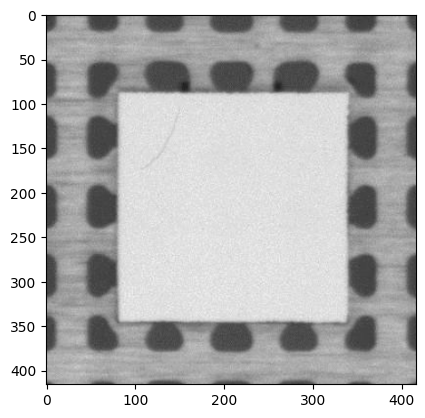

In [122]:
for i,j in train_dataset.skip(4):
    # i,j = aug_albument(i.numpy()/255,j.numpy())
    # print(np.max(i))
    plt.imshow(i.numpy()/255)
    break

In [123]:
train_dataset=train_dataset.map(process_data)

In [124]:
def preprocess(img, y):
    img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)
    labels = tf.numpy_function(generate_output, [y], Tout=[tf.float32,tf.float32,tf.float32])
    return img, labels[0],labels[1],labels[2]

train_dataset=train_dataset.map(preprocess)
val_dataset=val_dataset.map(preprocess)

242.16801
(52, 52, 9)
(26, 26, 9)
(13, 13, 9)
[[18 19]]
[array([0.90345824, 0.80165315, 0.29385856, 0.3445101 ], dtype=float32)]
[3]
242.16801


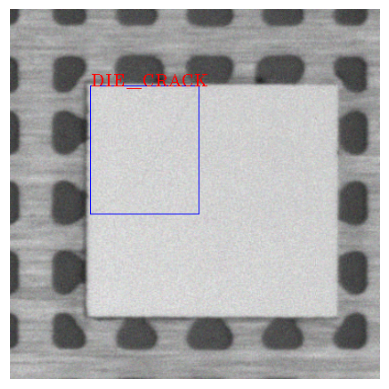

In [128]:
for i,j,k,l in train_dataset.skip(1):
    print(np.max(i))
    print(j.shape)
    print(k.shape)
    print(l.shape)
    boxes = tf.gather_nd(j,tf.where(j[...,0]!=0))
    position = tf.where(j[...,0]!=0).numpy()
    label_box = []
    label_class = []
    for box in boxes:
        label_box += [box[1:5].numpy()]
        label_class += [tf.argmax(tf.expand_dims(box[5:],axis=-1)).numpy()[0]]
    print(position)
    print(label_box)
    print(label_class)
    
    # break
    image = i.numpy()
    print(np.max(image))
    for k in range(len(label_box)):
        box = label_box[k]
        pos = position[k]
        xywh = box[0:4]
        cls = label_class[k]
        xmin = int((box[0]+pos[0])*8-box[2]*416/2)
        ymin = int((box[1]+pos[1])*8-box[3]*416/2)
        xmax = int((box[0]+pos[0])*8+box[2]*416/2)
        ymax = int((box[1]+pos[1])*8+box[3]*416/2)
        cv.rectangle(
          image,
          (int(xmin),int(ymin)),
          (int(xmax),int(ymax)),(0,0,255),1)
        cv.putText(
          image,
          classes[int(cls)],
          (int(xmin),int(ymin)),
          cv.FONT_HERSHEY_COMPLEX_SMALL,1,(255,0,0),1
          )
    plt.imshow(image/255.)
    plt.axis('off')
    break

255.0
tf.Tensor([[0.66798943 0.5844327  0.03439153 0.04485488 2.        ]], shape=(1, 5), dtype=float32)
[array([0.66798943, 0.5844327 , 0.03439153, 0.04485488], dtype=float32)]
[2]


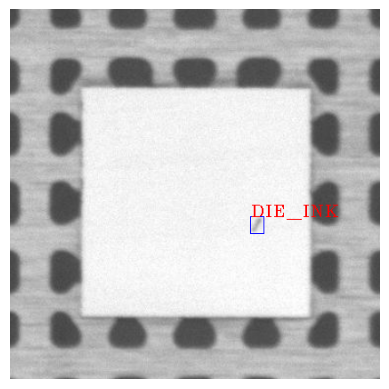

In [129]:
for i,j in test_dataset.skip(169):
    print(np.max(i))
    label_box = []
    label_class = []
    print(j)
    boxes = j.numpy()
    for box in boxes:
        label_box += [box[0:4]]
        label_class += [int(box[4])]
    print(label_box)
    print(label_class)
    
    # break
    image = i.numpy()
    for k in range(len(label_box)):
        box = label_box[k]
        pos = position[k]
        xywh = box[0:4]
        cls = label_class[k]
        xmin = int((box[0]*416)-box[2]*416/2)
        ymin = int((box[1]*416)-box[3]*416/2)
        xmax = int((box[0]*416)+box[2]*416/2)
        ymax = int((box[1]*416)+box[3]*416/2)
        cv.rectangle(
          image,
          (int(xmin),int(ymin)),
          (int(xmax),int(ymax)),(0,0,255),1)
        cv.putText(
          image,
          classes[int(cls)],
          (int(xmin),int(ymin)),
          cv.FONT_HERSHEY_COMPLEX_SMALL,1,(255,0,0),1
          )
    plt.imshow(image/255)
    plt.axis('off')
    break

In [130]:
train_dataset=(
  train_dataset.
  shuffle(buffer_size=1000,reshuffle_each_iteration=True).
  batch(8).
  prefetch(tf.data.AUTOTUNE)
)

val_dataset=(
  val_dataset.
  batch(8).
  prefetch(tf.data.AUTOTUNE)
)

# Model

In [131]:
class SpatialAttention(Layer):
    
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = Conv2D(filters=1, kernel_size=7, strides=1, padding='same')
        self.batch = BatchNormalization()
        self.activation = Activation('sigmoid')
        
    
    def call(self, input_features):
        avg_map = tf.reduce_mean(input_features,axis=-1,keepdims=True)
        max_map = tf.reduce_max(input_features,axis=-1,keepdims=True)
        concat_map = tf.concat([max_map,avg_map],axis=-1)

        output  = self.conv(concat_map)
        output  = self.batch(output)
        output  = self.activation(output)

        return Multiply()([input_features,output])

In [132]:
class ResBlock(Layer):
    def __init__(self, n_blocks, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.n_blocks = n_blocks
        self.conv_layers = []

    def build(self, input_shape):
        filters = input_shape[-1]
        for i in range(self.n_blocks):
            self.conv_layers.append(Conv2D(filters, 1, 1, padding='same',))
            self.conv_layers.append(BatchNormalization())
            self.conv_layers.append(Activation('mish'))
            self.conv_layers.append(Conv2D(filters, 3, 1, padding='same',))
            self.conv_layers.append(BatchNormalization())
            self.conv_layers.append(Activation('mish'))
#             self.conv_layers.append(Add())
        self.built = True

    def call(self, inputs):
        x = inputs
        for i in range(self.n_blocks):
            block_inputs = x
            x = self.conv_layers[i * 6](x)
            x = self.conv_layers[i * 6 + 1](x)
            x = self.conv_layers[i * 6 + 2](x)
            x = self.conv_layers[i * 6 + 3](x)
            x = self.conv_layers[i * 6 + 4](x)
            x = self.conv_layers[i * 6 + 5](x)
            x = Add()([x,block_inputs])
        return x

In [133]:
class ResBody(Layer):
    
    def __init__(self, filters, n_blocks):
        super(ResBody, self).__init__()
        self.n_blocks = n_blocks
        out_filters = filters
        if filters <=128:
            filters = 64
        else:
            filters = int(filters/2)
        # update -> modified self.conv1 filters = out_filters | weigh2,3,4,5 and adjust_loss use filters = filters
        self.conv1 = Conv2D(filters =out_filters, kernel_size = 3, strides = 2, padding = 'same')
        self.batch1 = BatchNormalization()
        self.activation1 = Activation('mish')
    
        self.conv2 = Conv2D(filters = filters, kernel_size = 1, strides = 1, padding = 'same')
        self.batch2 =  BatchNormalization()
        self.activation2 = Activation('mish')
        
        self.conv3 = Conv2D(filters = filters, kernel_size = 1, strides = 1, padding = 'same')
        self.batch3 = BatchNormalization()
        self.activation3 = Activation('mish')
        
        self.conv4 = Conv2D(filters = filters, kernel_size = 1, strides = 1, padding = 'same')
        self.batch4 = BatchNormalization()
        self.activation4 = Activation('mish')
        
        self.res = ResBlock(n_blocks)
        
        self.concat = Concatenate()
        
        self.conv5 = Conv2D(filters = out_filters, kernel_size = 1, strides = 1, padding = 'same')
        self.batch5 = BatchNormalization()
        self.activation5 = Activation('mish')
    
        
    def call(self, inputs):
        
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.activation1(x)
        
        route = self.conv2(x)
        route = self.batch2(route)
        route = self.activation2(route)
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.activation3(x)
        
        x = self.res(x)
    
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.activation4(x)
        
        x = self.concat([x,route])
        
        x = self.conv5(x)
        x = self.batch5(x)
        x = self.activation5(x)
        
        return x

In [134]:
class SPP(tf.keras.layers.Layer):
    
    def __init__(self):
        super(SPP, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 1, strides = 1, padding = 'same',kernel_initializer='he_normal')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.activation1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        self.maxpool_1 = tf.keras.layers.MaxPool2D(pool_size = 13, strides = 1, padding = 'same')
        self.maxpool_2 = tf.keras.layers.MaxPool2D(pool_size = 9, strides = 1, padding = 'same')
        self.maxpool_3 = tf.keras.layers.MaxPool2D(pool_size = 5, strides = 1, padding = 'same')

        self.concat = tf.keras.layers.Concatenate()
    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.activation1(x)
        
        x_1 = self.maxpool_1(x)
        x_2 = self.maxpool_2(x)
        x_3 = self.maxpool_3(x)

        x = self.concat([x_1,x_2,x_3,x])

        return x
        
    def compute_output_shape(self, input_shape):
        # Calculate the output shape here
        # For example, if input shape is (batch_size, height, width, channels)
        # and SPP performs a certain pooling, return the expected output shape
        output_shape = (input_shape[0], input_shape[1], input_shape[2], 2048)
        return output_shape

In [135]:
inputs = Input(shape=(416,416,3))
x = inputs
x = SpatialAttention()(x)

x = ResBody(64,1)(x)
x = ResBody(128,2)(x)
x = ResBody(256,8)(x)
x = ResBody(512,8)(x)
x = ResBody(1024,4)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='mish')(x)
x = BatchNormalization()(x)
x = Dense(256,activation='mish')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='mish')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(3,activation='softmax')(x)


backbone = Model(inputs,x)
backbone.summary()
backbone.load_weights('/kaggle/input/csp-darknet/darknet53.weights.h5')
# backbone.trainable=True

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 416, 416, 3)    │           103 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body (ResBody)              │ (None, 208, 208, 64)   │        65,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_1 (ResBody)            │ (None, 104, 104, 128)  │       196,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_2 (ResBody)            │ (None, 52, 52, 256)    │     1,767,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_3 (ResBody)            │ (None, 26, 26, 512)    │     7,041,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_4 (ResBody)            │ (None, 13, 13, 1024)   │    17,602,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,366,186 (104.39 MB)

 Trainable params: 27,329,064 (104.25 MB)

 Non-trainable params: 37,122 (145.01 KB)

In [136]:
inputs = backbone.input
x1 = backbone.get_layer('res_body_2').output
x2 = backbone.get_layer('res_body_3').output
outputs = backbone.get_layer('res_body_4').output

backbone_ = Model(inputs,outputs)
backbone_.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 416, 416, 3)    │           103 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body (ResBody)              │ (None, 208, 208, 64)   │        65,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_1 (ResBody)            │ (None, 104, 104, 128)  │       196,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_2 (ResBody)            │ (None, 52, 52, 256)    │     1,767,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_3 (ResBody)            │ (None, 26, 26, 512)    │     7,041,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_body_4 (ResBody)            │ (None, 13, 13, 1024)   │    17,602,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,673,191 (101.75 MB)

 Trainable params: 26,637,861 (101.62 MB)

 Non-trainable params: 35,330 (138.01 KB)

In [137]:
H,W = 416,416

inputs = backbone_.input

x = backbone_.output
x1 = backbone.get_layer('res_body_2').output
x2 = backbone.get_layer('res_body_3').output

x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal', )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (1,1), padding='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

x = SPP()(x)

x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

route = x

x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x2 = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.LeakyReLU(alpha=0.2)(x2)
x = tf.keras.layers.Concatenate()([x,x2])

x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal', )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal', )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)


route2 = x

x = tf.keras.layers.Conv2D(128, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x1 = tf.keras.layers.Conv2D(128, (1,1), padding ='same', kernel_initializer='he_normal',)(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.LeakyReLU(alpha=0.2)(x1)
x = tf.keras.layers.Concatenate()([x,x1])

x = tf.keras.layers.Conv2D(128, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(128, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(128, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

output1 = x

x = tf.keras.layers.Conv2D(256, (3,3),strides=2 ,padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Concatenate()([x,route2])

x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

output2 = x 

x = tf.keras.layers.Conv2D(512, (3,3),strides=2 ,padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Concatenate()([x,route])

x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (1,1), padding ='same', kernel_initializer='he_normal',)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

output3 = x


output1 = tf.keras.layers.Conv2D(256, (3,3), padding ='same', kernel_initializer='he_normal',)(output1)
output1 = tf.keras.layers.BatchNormalization()(output1)
output1 = tf.keras.layers.LeakyReLU(alpha=0.2)(output1)
output1 = tf.keras.layers.Dropout(0.3)(output1)
output1 = tf.keras.layers.Conv2D(27, (3,3), padding ='same', kernel_initializer='he_normal',)(output1)


output2 = tf.keras.layers.Conv2D(512, (3,3), padding ='same', kernel_initializer='he_normal',)(output2)
output2 = tf.keras.layers.BatchNormalization()(output2)
output2 = tf.keras.layers.LeakyReLU(alpha=0.2)(output2)
output2 = tf.keras.layers.Dropout(0.3)(output2)
output2 = tf.keras.layers.Conv2D(27, (3,3), padding ='same', kernel_initializer='he_normal',)(output2)

output3 = tf.keras.layers.Conv2D(1024, (3,3), padding ='same', kernel_initializer='he_normal',)(output3)
output3 = tf.keras.layers.BatchNormalization()(output3)
output3 = tf.keras.layers.LeakyReLU(alpha=0.2)(output3)
output3 = tf.keras.layers.Dropout(0.3)(output3)
output3 = tf.keras.layers.Conv2D(27, (3,3), padding ='same', kernel_initializer='he_normal',)(output3)


print(output1.shape, output2.shape, output3.shape)

model = Model(inputs,[output1,output2,output3])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


(None, 52, 52, 27) (None, 26, 26, 27) (None, 13, 13, 27)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention   │ (None, 416, 416,  │        103 │ input_layer[0][0] │
│ (SpatialAttention)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_body (ResBody)  │ (None, 208, 208,  │     65,408 │ spatial_attentio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_body_1          │ (None, 104, 104,  │    196,032 │ res_body[0][0]    │
│ (ResBody)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_body_2          │ (None, 52, 52,    │  1,767,808 │ res_body_1[0][0]  │
│ (ResBody)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_body_3          │ (None, 26, 26,    │  7,041,792 │ res_body_2[0][0]  │
│ (ResBody)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_body_4          │ (None, 13, 13,    │ 17,602,048 │ res_body_3[0][0]  │
│ (ResBody)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 13, 13,    │    524,800 │ res_body_4[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │      2,048 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 13, 13,    │  4,719,616 │ leaky_re_lu[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │      4,096 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 13, 13,    │    524,800 │ leaky_re_lu_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │      2,048 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spp (SPP)           │ (None, 13, 13,    │    264,704 │ leaky_re_lu_2[0]

 Total params: 64,843,000 (247.36 MB)

 Trainable params: 64,774,134 (247.09 MB)

 Non-trainable params: 68,866 (269.01 KB)

# MODEL TEST

In [138]:
import math
def compute_ciou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0], axis=-1)
    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0], axis=-1)

    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])
    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    iou = inter_square / union_square

    # Compute the center distance
    center_distance = tf.reduce_sum(tf.square(boxes1[..., :2] - boxes2[..., :2]), axis=-1)

    # Enclosing box
    enclose_lu = tf.minimum(boxes1_t[..., :2], boxes2_t[..., :2])
    enclose_rd = tf.maximum(boxes1_t[..., 2:], boxes2_t[..., 2:])
    enclose_wh = tf.maximum(0.0, enclose_rd - enclose_lu)
    enclose_diagonal = tf.reduce_sum(tf.square(enclose_wh), axis=-1)

    # Ensure no zero division in aspect ratio calculation
    boxes1_w = tf.maximum(boxes1[..., 2], 1e-10)
    boxes1_h = tf.maximum(boxes1[..., 3], 1e-10)
    boxes2_w = tf.maximum(boxes2[..., 2], 1e-10)
    boxes2_h = tf.maximum(boxes2[..., 3], 1e-10)

    arctan = tf.atan(boxes1_w / boxes1_h) - tf.atan(boxes2_w / boxes2_h)
    v = 4 / (tf.square(tf.constant(math.pi))) * tf.square(arctan)
    alpha = v / (1 - iou + v + tf.keras.backend.epsilon())
    ciou = iou - (center_distance / (enclose_diagonal + tf.keras.backend.epsilon()) + alpha * v)

    return ciou

In [139]:
def binary_crossentropy_loss(y_true, y_pred, label_smoothing=0.0):
    # Clip predictions to prevent log(0) which can cause NaNs
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Apply label smoothing to the target values
    y_true_smooth = y_true * (1 - label_smoothing) + (label_smoothing / 2)

    # Compute the Binary Cross Entropy for each sample in the batch
    loss = - (y_true_smooth * tf.math.log(y_pred) + (1 - y_true_smooth) * tf.math.log(1 - y_pred))
    
    # Sum the loss over the batch
    return tf.reduce_sum(loss)

In [140]:
@tf.function
def yolo_loss(y_true, y_pred_,split_size,anchors):
    in_shape = tf.shape(y_true)
    batch_size = tf.cast(in_shape[0],dtype = tf.float32)
    SPLIT_SIZE = in_shape[1]
    epsilon = tf.keras.backend.epsilon()

    target =  y_true[...,0]                
    obj = tf.where(target[:]==1)
    
    post_activation = []
    offset = 5+N_CLASSES
    for i in range (B):
        conf    = slice(offset * i, offset * i + 1, 1)
        xy      = slice(offset * i + 1, offset * i + 1 + 2, 1)
        wh      = slice(offset*i + 3,offset*i + 3 + 2, 1)
        cl      = slice(offset*i + 5, offset*i + 5 + N_CLASSES, 1)
        post_activation += [tf.clip_by_value(tf.sigmoid(y_pred_[..., conf]), epsilon, 1-epsilon)]
        post_activation += [tf.clip_by_value(tf.constant(1.2)*tf.sigmoid(y_pred_[..., xy]), epsilon, 1-epsilon)]
        post_activation += [tf.math.exp(tf.clip_by_value(y_pred_[..., wh], -15, 15))]
        post_activation += [tf.clip_by_value(tf.sigmoid(y_pred_[...,cl]),epsilon,1-epsilon)]
        
    y_pred = tf.concat(post_activation,axis=-1)    

    ####################### Object loss
    y_pred_extract = tf.gather_nd(y_pred, obj)       
    y_target_extract = tf.gather_nd(y_true, obj)                                           

    rescaler = tf.where(target[:]==1)* tf.cast(H // SPLIT_SIZE, tf.int64)
    upscaler = tf.concat([rescaler[:,1:], tf.zeros([tf.shape(rescaler)[0],2], dtype = tf.int64)],axis= -1)
    upscaler = tf.cast(upscaler, dtype = tf.float32)

    target_upscaler_2 = tf.repeat([[H//float(SPLIT_SIZE),W//float(SPLIT_SIZE),H,W]],                          
                       repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
    target_orig = upscaler + target_upscaler_2
    
    ciou = []
    pred_origs = []
    for i in range(B):
        anchor = anchors[i]
        pred_upscaler = (
            tf.repeat(
                [[H / float(SPLIT_SIZE), W / float(SPLIT_SIZE), anchor[0], anchor[1]]],
                repeats=[tf.shape(rescaler)[0]],
                axis=0,
            )
            * tf.cast(y_pred_extract[..., offset * i + 1 : offset * i + 5], dtype=tf.float32)
        )
        pred_orig = pred_upscaler + upscaler
        pred_origs.append(pred_orig)
        ciou.append(compute_ciou(target_orig, pred_orig))
    
    mask = tf.cast(tf.argmax(tf.stack(ciou, axis=-1), axis=-1), dtype=tf.int32)
   
    y_pred_joined = []
    for i in range(B):
        y_pred_joined.append(tf.expand_dims(y_pred_extract[..., offset * i],axis=0))

    y_pred_joined=tf.transpose(tf.concat(y_pred_joined, axis=0))
    obj_pred = tf.transpose(tf.gather_nd(y_pred_joined, tf.stack([tf.range(tf.shape(rescaler)[0]), mask], axis=-1)))
    
    obj_loss = binary_crossentropy_loss(tf.cast(tf.ones([tf.shape(rescaler)[0]]),dtype =tf.float32),tf.cast(obj_pred, dtype = tf.float32),0.1)
    obj_loss = obj_loss/batch_size
    
    ####################### No Object loss
    no_obj = []
    for i in range (B):
        conf    = slice(offset * i, offset * i + 1, 1)
        y_pred_noobj = tf.gather_nd(y_pred[...,conf], tf.where(target[:]==0)) 
        y_target_noobj = tf.zeros_like(y_pred_noobj)
        no_obj.append(binary_crossentropy_loss(tf.cast(y_target_noobj,dtype = tf.float32), tf.cast(y_pred_noobj, dtype = tf.float32)))
    
    no_obj_loss = tf.reduce_sum(no_obj)/batch_size
    
    ####################### For OBject class loss
    class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

    cls = []
    for i in range (B):
        cl    = slice(offset * i + 5, offset * i + 5 + N_CLASSES, 1)
        cls.append(tf.cast(tf.gather_nd(y_pred[...,cl], obj),dtype = tf.float32))

    y_pred_cls = tf.stack(cls,axis = 1)
    class_pred = tf.gather_nd(y_pred_cls, tf.stack([tf.range(tf.shape(rescaler)[0]),mask],axis = -1))
  
    class_loss = binary_crossentropy_loss(tf.cast(class_extract,dtype=tf.float32),tf.cast(class_pred,dtype =tf.float32),0.1)
        
    class_loss = class_loss/batch_size/4

    
    ####################### For Centre Loss
    centre_joined = tf.stack([tf.cast(pred_origs[0][...,:],dtype = tf.float32),
                              tf.cast(pred_origs[1][...,:],dtype = tf.float32),
                              tf.cast(pred_origs[2][...,:],dtype = tf.float32)],axis =1)
    centre_pred = tf.gather_nd(centre_joined, tf.stack([tf.range(tf.shape(rescaler)[0]),mask],axis = -1))
    centre_loss = tf.reduce_sum(1-compute_ciou(tf.cast(target_orig,dtype = tf.float32),tf.cast(centre_pred,dtype=tf.float32)))
    
    centre_loss = centre_loss/batch_size
   
    ####################### Total Loss
    lambda_coord = 8.
    lambda_no_obj = 0.04
    loss = lambda_coord*(centre_loss) + 1.0*obj_loss + (lambda_no_obj*no_obj_loss)  + 2.0*class_loss
    return loss, centre_loss, obj_loss, no_obj_loss, class_loss


In [ ]:
for i,j,k,l in val_dataset.take(1):
    print(np.where(j[...,0]!=0))
    res = model.predict(i[0:1])[0]
    yolo_loss(j[0:1],res,52,[[10.,13.],[16.,30.],[33.,23.]])
    break

In [145]:
# ANCHORS=[[[10.,13.],[16.,30.],[33.,23.]],
# [[30.,61.],[62.,45.],[59,100]],
# [[101.,90.],[134.,165.],[160.,220.]]]

ANCHORS=[[[7.,10.],[11.,24.],[26.,17.]],
[[40.,64.],[68.,48.],[65,106]],
[[95.,85.],[134.,165.],[180.,240.]]]


In [148]:
print(ANCHORS[0])
print(ANCHORS[1])
print(ANCHORS[2])


[[7.0, 10.0], [11.0, 24.0], [26.0, 17.0]]
[[40.0, 64.0], [68.0, 48.0], [65, 106]]
[[95.0, 85.0], [134.0, 165.0], [180.0, 240.0]]


In [149]:
class yolov4(tf.keras.Model):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.loss_tracker1 = tf.keras.metrics.Mean(name='loss_centre')
        self.loss_tracker2 = tf.keras.metrics.Mean(name='loss_obj')
        self.loss_tracker3 = tf.keras.metrics.Mean(name='loss_no_obj')
        self.loss_tracker4 = tf.keras.metrics.Mean(name='loss_class')

    @property
    def metrics(self):
        return [self.loss_tracker,
                self.loss_tracker1,
                self.loss_tracker2,
                self.loss_tracker3,
                self.loss_tracker4]
        
    def train_step(self,data):
        x_batch,y_batch1,y_batch2,y_batch3 = data
        with tf.GradientTape() as recorder:
            y_pred = self.model(x_batch, training=True)
            loss1, centre_loss1, obj_loss1, no_obj_loss1, class_loss1 = self.loss(y_batch1, y_pred[0],52,ANCHORS[0])
            loss2, centre_loss2, obj_loss2, no_obj_loss2, class_loss2 = self.loss(y_batch2, y_pred[1],26,ANCHORS[1])
            loss3, centre_loss3, obj_loss3, no_obj_loss3, class_loss3 = self.loss(y_batch3, y_pred[2],13,ANCHORS[2])
            loss = loss1 + loss2 + loss3
            centre_loss = centre_loss1 + centre_loss2 + centre_loss3
            obj_loss = obj_loss1 + obj_loss2 + obj_loss3
            no_obj_loss = no_obj_loss1 + no_obj_loss2 + no_obj_loss3
            class_loss = class_loss1 + class_loss2 + class_loss3
        partial_derivatives = recorder.gradient(loss, self.model.trainable_weights)    
        self.optimizer.apply_gradients(zip(partial_derivatives, self.model.trainable_weights))

        self.loss_tracker.update_state(loss)
        self.loss_tracker1.update_state(centre_loss)
        self.loss_tracker2.update_state(obj_loss)
        self.loss_tracker3.update_state(no_obj_loss)
        self.loss_tracker4.update_state(class_loss)
        return {'loss':self.loss_tracker.result(),
                'lcentre':self.loss_tracker1.result(),
                'lobj':self.loss_tracker2.result(),
                'lobj_none':self.loss_tracker3.result(),
                'lclass':self.loss_tracker4.result()}

In [150]:
def scheduler(epoch, lr):
    if epoch >=30:
        return lr*0.96
    else:
        return lr
    # return lr*0.95
    # return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'kaggle/working/yolo.weights.h5',
    monitor='loss',           # Metric to monitor
    save_best_only=True,      # Save only if the monitored metric improves
    save_weights_only=True,
    verbose=1                 # Print log messages
)

In [151]:
model1 = yolov4(model)
# model1.load_weights('/kaggle/input/yolov4_csp2/tensorflow2/default/1/yolo2.weights.h5')

In [ ]:
model1.model.summary()

In [153]:
model1.compile(
    tf.keras.optimizers.Adam(1e-3),
    loss = yolo_loss,
    # run_eagerly=True
    jit_compile=False
)

In [ ]:
history = model1.fit(
    train_dataset,
    epochs = 50,
    verbose= 1,
    shuffle=True,
    callbacks = [lr_callback,checkpoint_callback]
)

Epoch 1/50


2025-01-07 13:16:06.431497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - lcentre: 2.5998 - lclass: 2.0586 - lobj: 12.3228 - lobj_none: 763.9590 - loss: 67.7969
Epoch 1: loss improved from inf to 43.99785, saving model to kaggle/working/yolo.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - lcentre: 2.5984 - lclass: 2.0569 - lobj: 12.3172 - lobj_none: 759.6629 - loss: 67.6049 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - lcentre: 1.9440 - lclass: 1.5345 - lobj: 10.4129 - lobj_none: 86.6638 - loss: 32.5004
Epoch 2: loss improved from 43.99785 to 32.02493, saving model to kaggle/working/yolo.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 143s 982ms/step - lcentre: 1.9436 - lclass: 1.5344 - lobj: 10.4128 - lobj_none: 86.6509 - loss: 32.4965 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - lcentre: 1.7949 - lclass: 1.4522 - lobj: 10.1115 - lobj_none: 82.5163 - loss: 30.6758
Epoch 3: loss improved from 32.02493 to 30.56359, saving model to kaggle/working/yo

<function matplotlib.pyplot.show(close=None, block=None)>

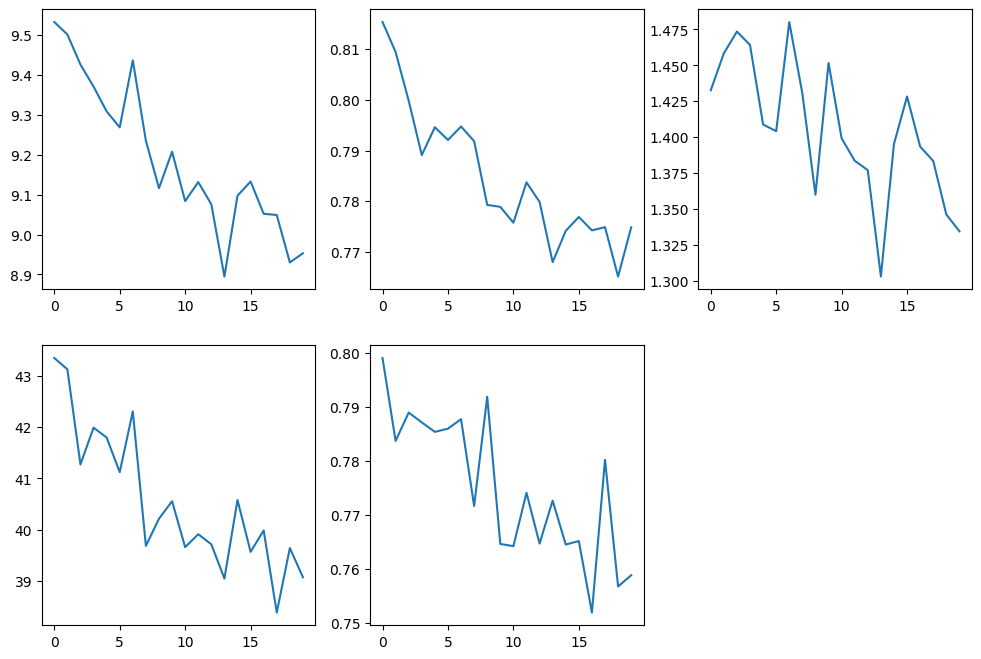

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(history.history['loss'])
plt.subplot(2,3,2)
plt.plot(history.history['lcentre'])
plt.subplot(2,3,3)
plt.plot(history.history['lobj'])
plt.subplot(2,3,4)
plt.plot(history.history['lobj_none'])
plt.subplot(2,3,5)
plt.plot(history.history['lclass'])
plt.show

# END MODEL TEST

# Testing

In [49]:
def calculate_iou(box1, box2):
  
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Compute intersection coordinates
    inter_xmin = max(xmin1, xmin2)
    inter_ymin = max(ymin1, ymin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymax = min(ymax1, ymax2)

    # Compute intersection area
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Compute areas of the individual boxes
    area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Compute union area
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

def calculate_ap(predicted_boxes, ground_truth_boxes, iou_threshold=0.5):
    # Sort the predictions by confidence score in descending order
    predicted_boxes = sorted(predicted_boxes, key=lambda x: x[4], reverse=True)
    
    true_positives = []
    false_positives = []
    false_negatives = []

    # Initialize ground truth matched flags
    ground_truth_matched = [False] * len(ground_truth_boxes)

    # Loop through each predicted box and calculate IoU with ground truths
    for pred in predicted_boxes:
        pred_box = pred[:4]  # [xmin, ymin, xmax, ymax]
        pred_confidence = pred[4]  # Confidence score
        
        best_iou = 0
        best_gt_index = -1
        
        # Compare prediction with each ground truth
        for idx, gt in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred_box, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_index = idx
        
        # If IoU >= threshold, it's a True Positive (TP), else it's a False Positive (FP)
        if best_iou >= iou_threshold and not ground_truth_matched[best_gt_index]:
            true_positives.append(1)
            false_positives.append(0)
            ground_truth_matched[best_gt_index] = True
        else:
            true_positives.append(0)
            false_positives.append(1)

    # False Negatives: Ground truth boxes that were not matched to any prediction
    false_negatives = [1 if not matched else 0 for matched in ground_truth_matched]
    
    return  np.count_nonzero(true_positives), np.count_nonzero(false_positives), len(ground_truth_boxes), #ap



In [50]:
true_positive = 0
false_positive = 0

def ap(x_train, y_true,display_gt=True):
    # try:
        img = x_train.numpy()
        image = x_train.numpy()
        anchors = [[[10.,13.],[16.,30.],[33.,23.]],[[30.,61.],[62.,45.],[59,100]],[[101.,90.],[134.,165.],[160.,220.]]]

        THRESH = 0.2
        THRESH_HIGH= 1.0
        final_boxes=[]
        final_scores=[]
        predict=model.predict(np.expand_dims(image, axis = 0))
        for scale in range(3):
            output_ = predict[scale]
        
            stride = output_.shape[1]
            epsilon = tf.keras.backend.epsilon()
            post_activation = []
            offset = 5+N_CLASSES
            
            for i in range (B):
                conf    = slice(offset * i, offset * i + 1, 1)
                xy      = slice(offset * i + 1, offset * i + 1 + 2, 1)
                wh      = slice(offset*i + 3,offset*i + 3 + 2, 1)
                cl      = slice(offset*i + 5, offset*i + 5 + N_CLASSES, 1)
                post_activation += [tf.clip_by_value(tf.sigmoid(output_[..., conf]), epsilon, 1-epsilon)]
                post_activation += [tf.clip_by_value(tf.constant(1.2)*tf.sigmoid(output_[..., xy]), epsilon, 1-epsilon)]
                post_activation += [tf.math.exp(tf.clip_by_value(output_[..., wh], -15, 15))]
                post_activation += [tf.clip_by_value(tf.sigmoid(output_[...,cl]),epsilon,1-epsilon)]
        
            output = tf.concat(post_activation,axis=-1)
        
    
            object_positions=tf.concat(
                [tf.where(output[...,0]>=THRESH),tf.where(output[...,9]>=THRESH),tf.where(output[...,18]>=THRESH)],axis=0)
  
            selected_output=tf.gather_nd(output,object_positions)
  
            for i,pos in enumerate(object_positions):
              for j in range(3):      
                if selected_output[i][j*9]>=THRESH: #and selected_output[i][j*9]<THRESH_HIGH:
                  output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*9)+1:(j*9)+5],dtype=tf.float32)
        
                  x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*(H//stride)
                  y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*(W//stride)
        
                  x_width,y_height=tf.math.abs(anchors[scale][j][0]*output_box[2]),tf.math.abs(anchors[scale][j][1]*output_box[3])
        
                  x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
                  x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))
        
                  if(x_min<=0):x_min=0
                  if(y_min<=0):y_min=0
                  if(x_max>=W):x_max=W
                  if(y_max>=H):y_max=H
                  final_boxes.append(
                      [x_min,y_min,x_max,y_max,
                      str(classes[tf.argmax(selected_output[...,(j*9)+5:(j*9)+9],axis=-1)[i]])])
                  final_scores.append(selected_output[i][j*9])
     
        final_boxes=np.array(final_boxes)
        nms_output = []
        if len(final_boxes !=0):
            object_classes=final_boxes[...,4]
            nms_boxes=final_boxes[...,0:4]
        
            nms_output=tf.image.non_max_suppression(
                nms_boxes,final_scores,max_output_size=len(y_true),iou_threshold=0.2,
                score_threshold= float('-inf')#tf.constant(1.0)*np.mean(final_scores) if len(final_scores)>1 else np.mean(final_scores)#float('-inf')
            )
        # print(nms_output)
        predicted = []
        for index,i in enumerate(nms_output):
            predicted.append([int(final_boxes[i][0]),int(final_boxes[i][1]),int(final_boxes[i][2]),int(final_boxes[i][3]),final_scores[nms_output.numpy()[index]].numpy()])
            # print(nms_output.numpy()[index])
            cv.rectangle(
              img,
              (int(final_boxes[i][0]),int(final_boxes[i][1])),
              (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
            cv.putText(
              img,
              str(tf.cast(final_scores[nms_output.numpy()[index]],dtype=tf.float16).numpy()),
              (int(final_boxes[i][0]),int(final_boxes[i][1])),
              cv.FONT_HERSHEY_COMPLEX_SMALL,0.6,(255,0,0),1
              )
            cv.putText(
              img,
              final_boxes[i][-1],
              (int(final_boxes[i][0]),int(final_boxes[i][3])),
              cv.FONT_HERSHEY_COMPLEX_SMALL,0.6,(255,0,0),1
              )
        ground_truth = []
        for i in y_true:
          
            x_min = int((i[0]-i[2]/2)*H)
            y_min = int((i[1]-i[3]/2)*W)
            x_max = int((i[0]+i[2]/2)*H)
            y_max = int((i[1]+i[3]/2)*W)

            ground_truth.append([x_min,y_min,x_max,y_max])

            if display_gt == True:
                cv.rectangle(
                  img,
                  (x_min,y_min),
                  (x_max,y_max),(0,255,0),1
                )
                cv.putText(
                  img,
                  '1',
                  (x_min,y_min),
                  cv.FONT_HERSHEY_COMPLEX_SMALL,0.5,(0,255,0),1
                )
                cv.putText(
                  img,
                  classes[int(i.numpy()[4])],
                  (x_min+5,y_max+5),
                  cv.FONT_HERSHEY_COMPLEX_SMALL,0.5,(0,255,0),1
                  )
        aps = calculate_ap(predicted,ground_truth,0.5)
        print(ground_truth)
        print(predicted)
        
        print(aps)
        return aps,cv.resize(img/255,(H,W))
        

In [51]:
count = 0
true_positives=[]
false_positives=[]
ground_truths = 0
res_imgs = []
for i,j in test_dataset:
    if count == 5:
        break
    res = ap(i,j)
    if res is not None:
        print(res[0])
        true_positives.append(res[0][0])
        false_positives.append(res[0][1])
        ground_truths+=res[0][2]
        res_imgs.append(res[1])
    count+=1

true_positives_cumsum = np.cumsum(true_positives)
false_positives_cumsum = np.cumsum(false_positives)
print(true_positives_cumsum)
print(false_positives_cumsum)
precision = true_positives_cumsum/(true_positives_cumsum+false_positives_cumsum+1e-7)
recall = true_positives_cumsum/ground_truths
print(precision)
print(recall)
print(ground_truths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[80, 119, 337, 139]]
[[79, 123, 339, 138, 0.89600027]]
(1, 0, 1)
(1, 0, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[192, 99, 208, 290]]
[[178, 111, 220, 281, 0.9551133]]
(0, 1, 1)
(0, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[150, 153, 303, 165]]
[[137, 131, 301, 182, 0.91726995]]
(0, 1, 1)
(0, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[250, 116, 282, 284]]
[[248, 129, 294, 286, 0.97126114]]
(1, 0, 1)
(1, 0, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[161, 109, 241, 288]]
[[154, 121, 244, 296, 0.95346457]]
(1, 0, 1)
(1, 0, 1)
[1 1 1 2 3]
[0 1 2 2 2]
[0.9999999  0.49999998 0.33333332 0.49999999 0.59999999]
[0.2 0.2 0.2 0.4 0.6]
5


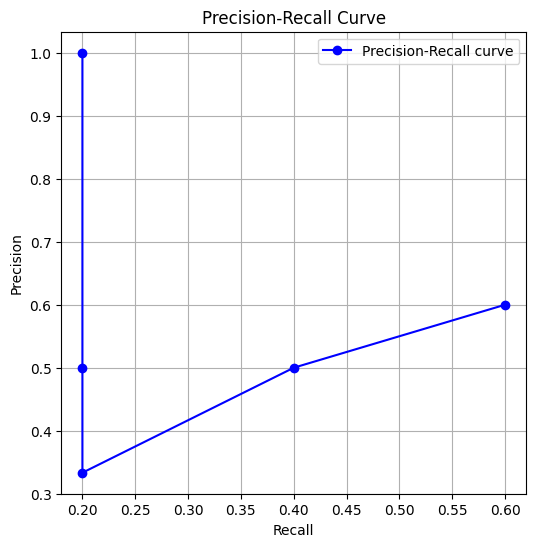

In [52]:
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='o', color='b', label='Precision-Recall curve')

# Adding labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Adding grid for better visibility
plt.grid(True)

# Displaying the plot
plt.legend(loc='best')
plt.savefig('Precision-Recall')
plt.show()

In [53]:
print(np.trapz(precision,recall,1,-1))

0.1933333285222223


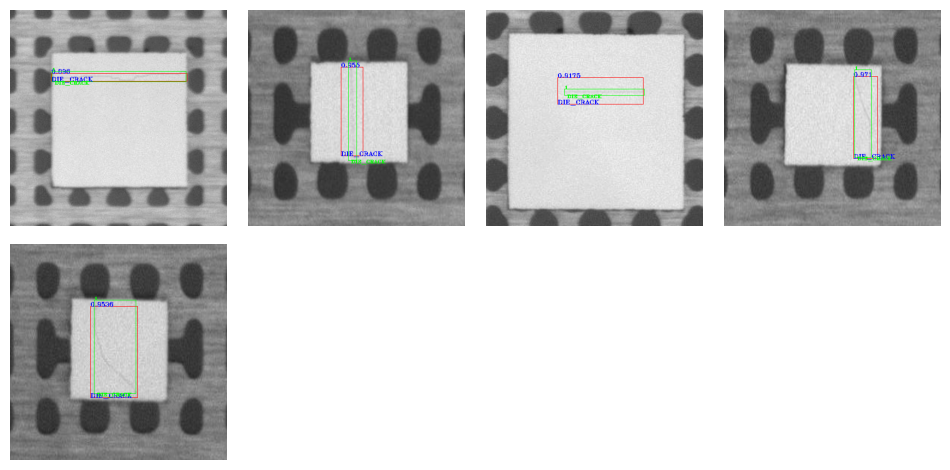

In [54]:
plt.figure(figsize=(12,12))
for index,im in enumerate(res_imgs[0:5]):
    plt.subplot(4,4,index+1)
    if (np.shape(im)!=()):
        plt.imshow(cv.cvtColor(cv.resize(im,(416,416)),cv.COLOR_BGR2RGB))
        # print(np.max(im))
        plt.axis('off')
    else: plt.imshow(np.ones((416,416,3)))
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig('res_ink110', dpi=400, bbox_inches='tight')
plt.show()

In [46]:
count = 0 
GROUND  = []
PREDICT = []
THRESH = 0.2
THRESH_HIGH= 1.0
offset = 5+N_CLASSES
epsilon = tf.keras.backend.epsilon()

for image,label in test_dataset:
    if count == 50:#len(test_dataset):
        break
    true_boxes = []
    for k in label:
        x_min = int((k[0]-k[2]/2)*H)
        y_min = int((k[1]-k[3]/2)*W)
        x_max = int((k[0]+k[2]/2)*H)
        y_max = int((k[1]+k[3]/2)*W)
        true_boxes.append([x_min, y_min, x_max, y_max,k[-1].numpy().astype('int32')])
    GROUND.append(true_boxes)
    
    anchors = [[[10.,13.],[16.,30.],[33.,23.]],[[30.,61.],[62.,45.],[59,100]],[[101.,90.],[134.,165.],[160.,220.]]]
    final_boxes=[]
    final_scores=[]
    predict=model.predict(np.expand_dims(image, axis = 0))
    
    for scale in range(3):
        output_ = predict[scale]

        stride = output_.shape[1]        
        post_activation = []
        
        for i in range (B):
            conf    = slice(offset * i, offset * i + 1, 1)
            xy      = slice(offset * i + 1, offset * i + 1 + 2, 1)
            wh      = slice(offset*i + 3,offset*i + 3 + 2, 1)
            cl      = slice(offset*i + 5, offset*i + 5 + N_CLASSES, 1)
            post_activation += [tf.clip_by_value(tf.sigmoid(output_[..., conf]), epsilon, 1-epsilon)]
            post_activation += [tf.clip_by_value(tf.constant(1.2)*tf.sigmoid(output_[..., xy]), epsilon, 1-epsilon)]
            post_activation += [tf.math.exp(tf.clip_by_value(output_[..., wh], -15, 15))]
            post_activation += [tf.clip_by_value(tf.sigmoid(output_[...,cl]),epsilon,1-epsilon)]
    
        output = tf.concat(post_activation,axis=-1)
        object_positions=tf.concat(
            [tf.where(output[...,0]>=THRESH),tf.where(output[...,9]>=THRESH),tf.where(output[...,18]>=THRESH)],axis=0)
        selected_output=tf.gather_nd(output,object_positions)

        for i,pos in enumerate(object_positions):
          for j in range(3):      
            if selected_output[i][j*offset]>=THRESH: #and selected_output[i][j*9]<THRESH_HIGH:
              output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*offset)+1:(j*offset)+5],dtype=tf.float32)
    
              x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*(H//stride)
              y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*(W//stride)
    
              x_width,y_height=tf.math.abs(anchors[scale][j][0]*output_box[2]),tf.math.abs(anchors[scale][j][1]*output_box[3])
    
              x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
              x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))
    
              if(x_min<=0):x_min=0
              if(y_min<=0):y_min=0
              if(x_max>=W):x_max=W
              if(y_max>=H):y_max=H
              final_boxes.append(
                  [x_min,y_min,x_max,y_max,
                  tf.argmax(selected_output[...,(j*offset)+5:(j*offset)+offset],axis=-1)[i]])
              final_scores.append(selected_output[i][j*(offset)])
    # print(final_boxes) 
    final_boxes=np.array(final_boxes)

    nms_output = []
    if len(final_boxes !=0):
        object_classes=final_boxes[...,4]
        nms_boxes=final_boxes[...,0:4]
        nms_output=tf.image.non_max_suppression(
            nms_boxes,final_scores,max_output_size=len(label),iou_threshold=0.2,
            score_threshold= float('-inf')#tf.constant(1.0)*np.mean(final_scores) if len(final_scores)>1 else np.mean(final_scores)#float('-inf')
        )
        # print(nms_output)
        predict= []
        for index,i in enumerate(nms_output):
            combined_res = final_boxes[i].astype('int32').tolist()
            combined_res.append(final_scores[nms_output[index]].numpy())
            predict.append(combined_res)
        PREDICT.append(predict)
    count+=1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [47]:
def plot_precision_recall_curve(coco_eval):
    """
    Plots the Precision-Recall curve for mAP at IoU=0.5:0.95.

    :param coco_eval: COCOeval object after evaluation
    """
    # Recall thresholds
    recall = coco_eval.params.recThrs  # Array of recall thresholds

    # Extract precision values
    # Dimensions: [IoU thresholds, Recall thresholds, Categories, Areas, MaxDet]
    precision = coco_eval.eval['precision']
    precision[np.where(precision<0)]=0

    # Average over categories, areas, and maxDet (optional)
    mean_precision = np.mean(precision, axis=(2, 3, 4))  # Average across categories, areas, and maxDet
    # Plot for each IoU threshold
    iou_thresholds = coco_eval.params.iouThrs
    for i, iou_threshold in enumerate(iou_thresholds[0:]):
        plt.plot(recall, mean_precision[i, :], label=f"IoU={iou_threshold:.2f}")

    # Add labels and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (mAP IoU=0.5:0.95)")
    plt.legend()
    plt.grid()
    plt.show()

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

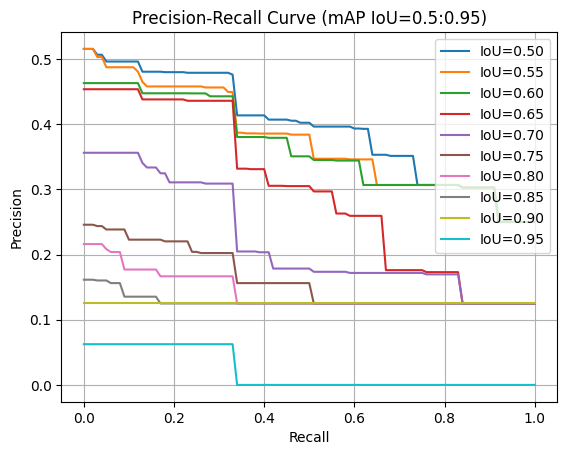

Mean Average Precision (mAP): 0.38029636285145707


In [48]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def calculate_map(coco_gt, coco_dt, iou_type="bbox"):
    """
    Calculate the mAP using COCO API.

    :param coco_gt: COCO ground truth object (COCO class instance)
    :param coco_dt: COCO detections object (COCO class instance)
    :param iou_type: Type of evaluation ('bbox' for bounding boxes, 'segm' for segmentation masks)
    :return: Mean Average Precision (mAP)
    """
    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, iouType=iou_type)

    # Evaluate the results
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    plot_precision_recall_curve(coco_eval)
    # Return the mean Average Precision (mAP)
    return coco_eval.stats[0]  # mAP at IoU=0.5:0.95

def create_coco_format_data(ground_truths, predictions):
    """
    Converts ground truths and predictions to COCO format.

    :param ground_truths: List of ground truth boxes per image
                          [[x_min, y_min, x_max, y_max, class_id], ...]
    :param predictions: List of predicted boxes per image
                        [[x_min, y_min, x_max, y_max, class_id, confidence], ...]
    :return: coco_gt (ground truth COCO object), coco_dt (predictions COCO object)
    """
    # Create COCO format for ground truth
    coco_gt = {
        "images": [{"id": i, "width": H, "height": W} for i in range(len(ground_truths))],
        "annotations": [],
        "categories": [{"id": i, "name": str(i)} for i in range(len(set(gt[-1] for gt in sum(ground_truths, []))))]  # Fixed syntax error
    }

    # Ground truth annotations
    annotation_id = 0
    for i, gt_image in enumerate(ground_truths):
        for gt in gt_image:
            bbox = [gt[0], gt[1], gt[2] - gt[0], gt[3] - gt[1]]  # Convert to [x, y, w, h]
            coco_gt["annotations"].append({
                "id": annotation_id,
                "image_id": i,
                "category_id": int(gt[4]),
                "bbox": bbox,
                "area": bbox[2] * bbox[3],
                "iscrowd": 0
            })
            annotation_id += 1
    
    # Create COCO format for predictions (same structure as ground truth)
    coco_dt = {
        "images": [{"id": i, "width": H, "height": W} for i in range(len(predictions))],
        "annotations": [],
        "categories": [{"id": i, "name": str(i)} for i in range(len(set(pred[-2] for pred in sum(predictions, []))))]  # Fixed syntax error
    }
    
    # Prediction annotations
    annotation_id = 0
    for i, pred_image in enumerate(predictions):
        for pred in pred_image:
            bbox = [pred[0], pred[1], pred[2] - pred[0], pred[3] - pred[1]]  # Convert to [x, y, w, h]
            coco_dt["annotations"].append({
                "id": annotation_id,
                "image_id": i,
                "category_id": int(pred[4]),
                "bbox": bbox,
                "score": pred[5],
                "area": bbox[2] * bbox[3],
                "iscrowd": 0
            })
            annotation_id += 1
    
    # Now that the dataset is structured, create COCO instances
    coco_gt_instance = COCO()
    coco_gt_instance.dataset = coco_gt  # Assign the ground truth data to the COCO instance
    coco_gt_instance.createIndex()

    coco_dt_instance = COCO()
    coco_dt_instance.dataset = coco_dt  # Assign the detection data to the COCO instance
    coco_dt_instance.createIndex()
    
    return coco_gt_instance, coco_dt_instance

# Convert to COCO format
coco_gt, coco_dt = create_coco_format_data(GROUND, PREDICT)

# Compute mAP using COCO evaluation
mAP = calculate_map(coco_gt, coco_dt, iou_type="bbox")
print(f"Mean Average Precision (mAP): {mAP}")
